# Exercise Session 1: Getting Started with Computer Vision

The goals of this exercise are:
* getting started with Python for image manipulation
* getting familiar with the basic image manipulation functions
* implementing some simple real-world Computer Vision algorithms

In [78]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

from skimage import measure, color
from os import listdir

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['image.cmap'] = 'gray'

## Exercise 1: Image Segmentation

In many vision applications, it is useful to separate out the regions of the image corresponding to objects in which we are interested in the regions of the image that correspond to the background. Thresholding often provides an easy and convenient way to perform this segmentation on the basis of the different intensities or colours in the foreground and background regions of an image.

The input to a thresholding operation is typically a grayscale or colour image. In the simplest implementation, the output is a binary image representing the segmentation. Black pixels correspond to background and white pixels correspond to foreground (or vice versa). Multiple thresholds can be specified, so that a band of intensity values can be set to white while everything else is set to black.

If it is possible to separate out the foreground of an image on the basis of pixel intensity, then the intensity of pixels within foreground objects must be distinctly different from the intensity of pixels within the background. In this case, we expect to see a distinct peak in the histogram corresponding to foreground objects such that thresholds can be chosen to isolate this peak accordingly. If such a peak does not exist, then it is unlikely that simple thresholding will produce a good segmentation.
 


* Read and display the image "wdg.png" using function ```cv2.imread()```. Convert it from color to greyscale if necessary using function ```cv2.cvtColor()```. Visualize the results using ```plt.imshow()``` function.</li>

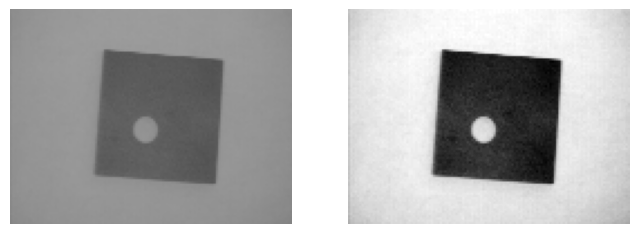

In [79]:
#add your code here
fig, (ax1, ax2) = plt.subplots(1, 2)
img = cv2.imread('images/wdg.png')
ax1.imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ax2.imshow(img);
ax1.set_axis_off();
ax2.set_axis_off();

* Write a function to threshold a gray scale image by using two threshold values as shown above. The values must satisfy the following conditions:
\begin{align}
Th1 < Th2 
\newline 
Th1 > 0 
\newline 
Th2 < I_{max}
\end{align}
where $I_{max}$ is the maximum intensity of the image.

In [80]:
#add your code here

def binary_threshold(img: np.ndarray, th1: int, th2: int) -> np.ndarray:
    out = img.copy()
    out = np.where(out < th1, 0, th2)
    return out

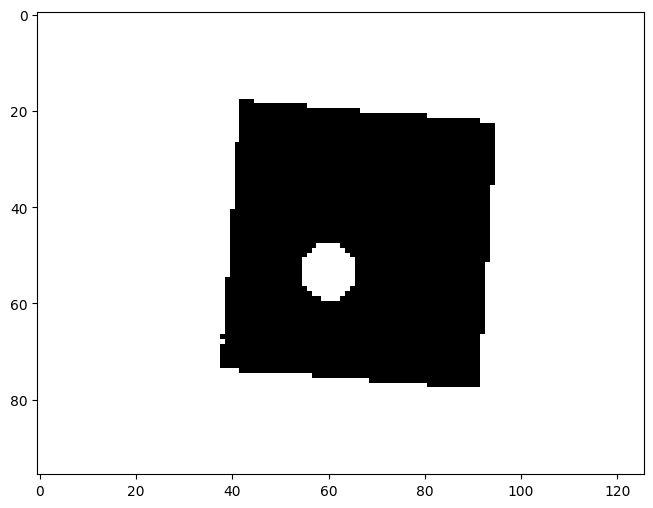

In [81]:
imax = np.max(img)

th1 = 110
th2 = imax

plt.imshow(binary_threshold(img, th1, th2));

* Take a look at the pixels intensity histogram using function ```matplotlib.pyplot.hist()``` and choose the best threshold values and segment the image.</li>

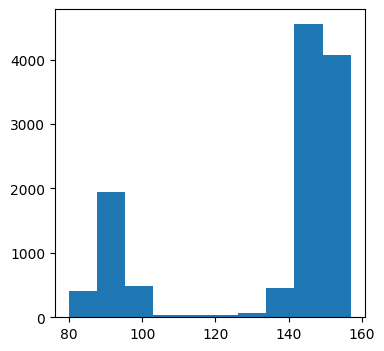

In [82]:
#add your code here
plt.subplots(figsize=(4,4))
plt.hist(img.flatten());

* Repeat the same steps for images "brain.png" and "shading.png". What do you notice? What are the drawbacks of this segmentation method? </li>

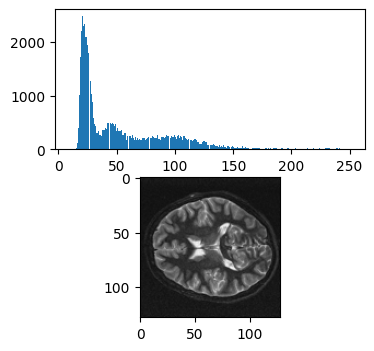

In [83]:
#add your code here
#add your code here
img = cv2.imread('images/brain.png')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4,4))
ax1.hist(img.flatten(), 256);
ax2.imshow(img);

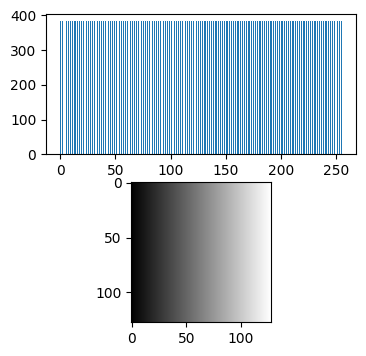

In [84]:
img = cv2.imread('images/shading.png')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4,4))
ax1.hist(img.flatten(), 256);
ax2.imshow(img);

## Exercise 2: Background Substraction

Background subtraction is an important preprocessing step of many algorithms, e.g. object detection. In the following exercises we will try to subtract the scene background using multiple images.

### 2.1 Extracting a moving object

* Load the "street1.tiff" and the "street2.tiff" images. Visualize them.

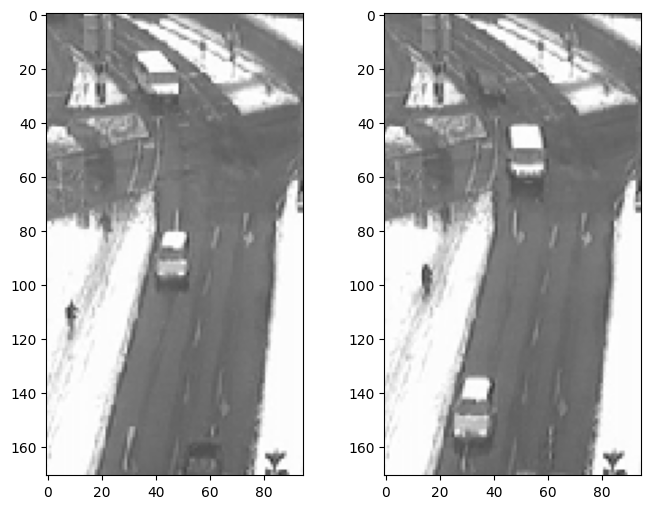

In [85]:
#add your code here.  
fig, (ax1, ax2) = plt.subplots(1, 2)
street1_img = cv2.imread('images/street1.tiff')
ax1.imshow(street1_img);

street2_img = cv2.imread('images/street2.tiff')
ax2.imshow(street2_img);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


######


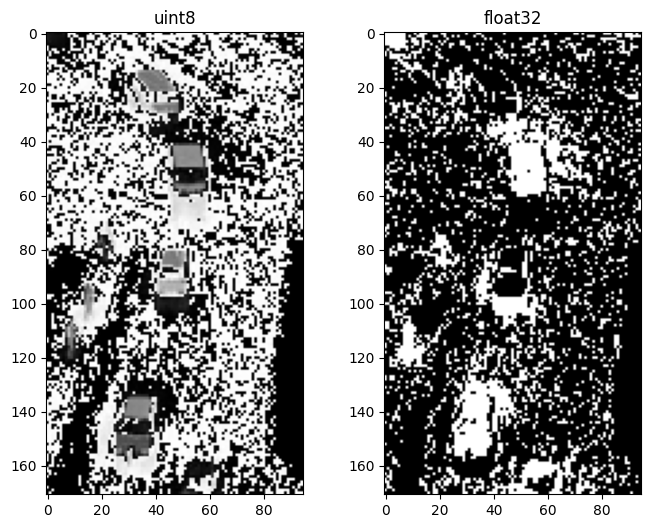

In [86]:
fig, (ax1, ax2) = plt.subplots(1, 2)

image_diff = street2_img - street1_img
ax1.imshow(image_diff);
ax1.set_title('uint8')

# Transform the 8-bit images into float images. You can use image attribute ```dtype``` to check
# the type of image. To perform the type casting you can use ```np.float32()``` function. 
# add your code here. 
street1_img = np.float32(street1_img)
street2_img = np.float32(street2_img)

ax2.set_title('float32')
# Subtract the second image from the first one using basic matrix arithmetic operations.
# Visualize the results. Why was it important to do the casting before subtracting the images? 
# add your code here. Assign the difference to 'image_diff'
print('######')
image_diff = street2_img - street1_img
ax2.imshow(image_diff);

### 2.2 Building a background model
For this exercise, you are given a sequence of images that contains pedestrians and we wish to segment with a background subtraction algorithm.

* Load and create a stack of images from the images inside ```images/sequence1```. Build a "background model" by averaging out the set of given images. Detect pedestrians
 subtracting the background model from the original images and applying the right threshold.

Text(0.5, 1.0, 'Background model')

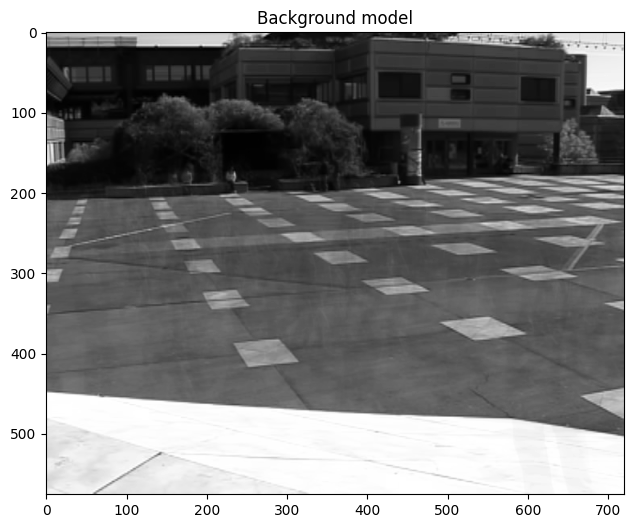

In [87]:
sq_of_images = listdir('images/sequence1/')  
stack = np.array([cv2.imread('images/sequence1/' + img, cv2.IMREAD_GRAYSCALE) for img in sq_of_images if img.endswith(".jpg")])
# 'sq_of_images') holds the list of image names. Create an image stack using them.
    
# Compute the mean image using the stack and assign it to 'mean_image'.
mean_image = np.uint8(np.mean(stack, axis = 0))
plt.imshow(mean_image) 
plt.title('Background model')

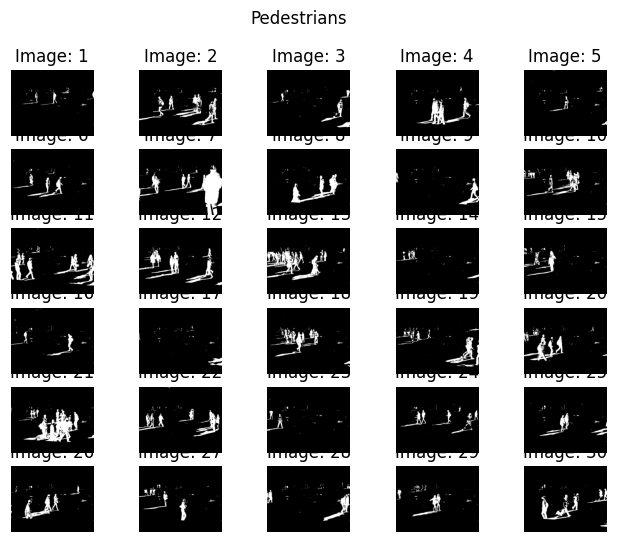

In [88]:
T = 30
plt.figure(2)
plt.suptitle('Pedestrians')

# First convert the mean image to grayscale.
# When subtracting, each image must also be converted to grayscale.
mean_image = np.float32(mean_image)
stack = np.float32(stack)

for i in range(len(stack)):
    # Compute the foreground image here. Assign it to 'foreground' variable.
    foreground = np.abs((stack[i] - mean_image)) > T
    plt.subplot(6,5,i+1)
    plt.imshow(foreground)
    plt.axis('off')
    plt.title('Image: ' + str(i+1)) 

* Create a more sophisticated background model, where each pixel can be modeled with a Gaussian distribution. We can classify a pixel as background if its current intensity ($I_t$) lies within some confidence interval of its distribution’s mean ($\mu(t)$):


\begin{align}
\frac{\mid{(I_t - \mu_t)}\mid}{\sigma_t} > T \rightarrow Foreground 
\newline
\frac{\mid{(I_t - \mu_t)}\mid}{\sigma_t} < T \rightarrow Background 
\end{align}

$\sigma_t$ is the standard deviation of the pixel $t$ in the background model. $T$ is the threshold.

What difference do you notice between the two approaches? How does changing
the threshold affect them?

In [89]:
std = np.std(stack, axis=0)
std[std==0] = 1e-45

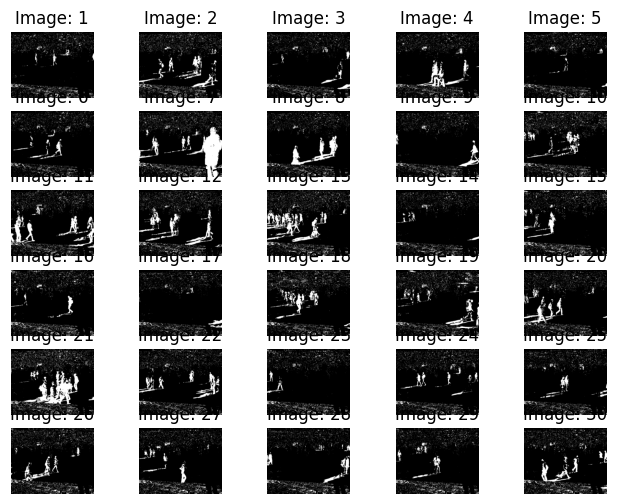

In [90]:
# Threshold. T = 2 means we consider any pixel that is more than 2*std away from the mean as
# a foreground pixel. 
T = 2
 
for i in range(len(stack)):
    foreground = (np.abs(stack[i]-mean_image)/std) > T
    plt.subplot(6,5,i+1)
    plt.imshow(foreground)
    plt.axis('off')
    plt.title('Image: ' + str(i+1)) 

## Exercise 3: Connected Components

Segmentation can be also done for colour images. It is also often a first step for the further analysis e.g. measuring properties of the object. Here our goal is to count the number of apples in the image below.



* Read and display"apples.jpg" image.

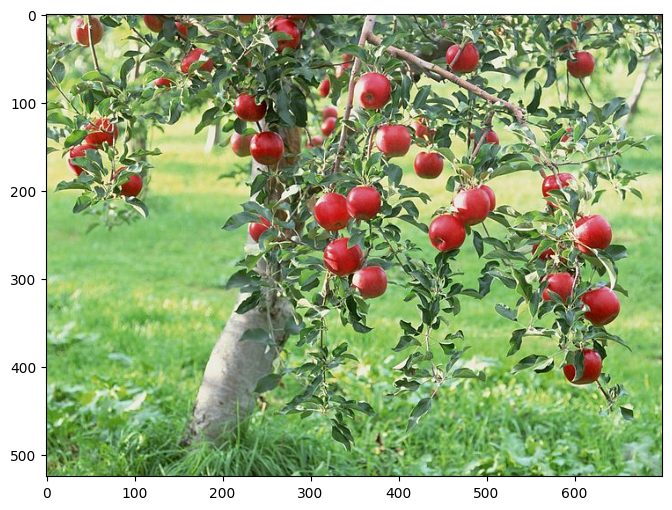

In [91]:
#add your code here
img_apples = cv2.imread('images/apples.jpg')
b,g,r = cv2.split(img_apples)       # get b,g,r
img_apples = cv2.merge([r,g,b])     # switch it to rgb
plt.imshow(img_apples);

* Check the size of the image. Compared to the previous images it should have an additional dimension corresponding to three colour channels: red, green and blue. Visualize those 3 channels separately.

Text(0.5, 1.0, 'Blue channel')

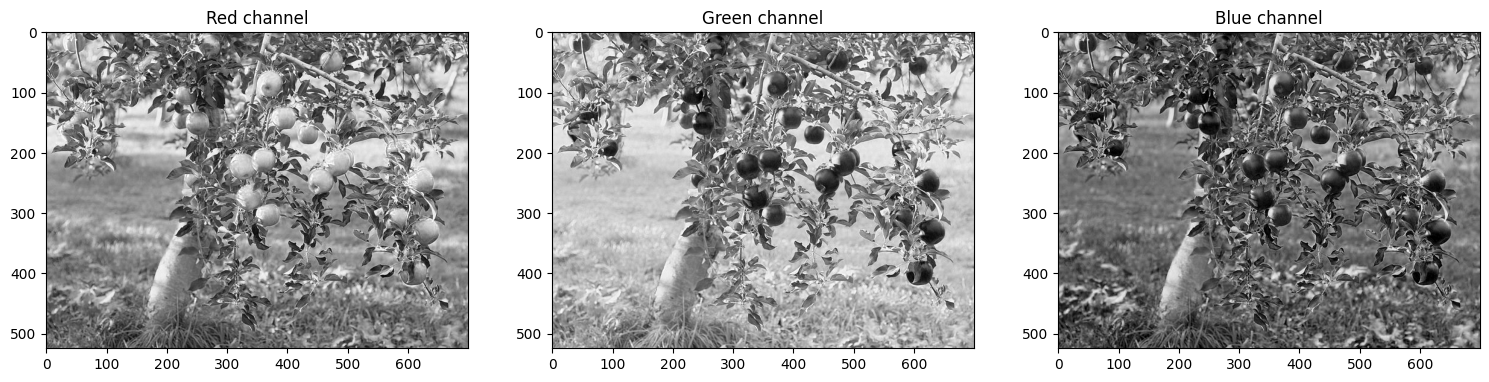

In [94]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18.5, 10.5)
# add your code for visualizing three channels
axes[0].imshow(img_apples[:,:,0]);
axes[0].set_title("Red channel")
axes[1].imshow(img_apples[:,:,1]);
axes[1].set_title("Green channel")
axes[2].imshow(img_apples[:,:,2]);
axes[2].set_title("Blue channel")

* Try to obtain a binary image such that binary image == 1 for pixels representing apples and 0 otherwise. Which channel(s) would you use for that?

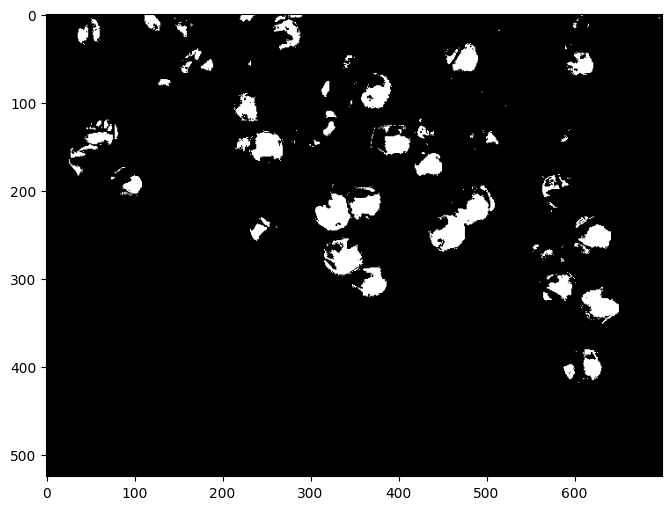

In [123]:
bin_img = np.zeros(img_apples.shape[0:2])
#add your code fot thresholding the image
bin_img[(img_apples[:, :, 0] > 100) & (img_apples[:, :, 1] < 80)] = 255
plt.imshow(bin_img)

* Count the number of connected components in your binary image (here corresponding to apples). For this, you can use function ```measure.label()```. Its output is an array of the same size as input binary image, with each pixel assigned to a different connected component (ID). Visualize the image with detected connected components.

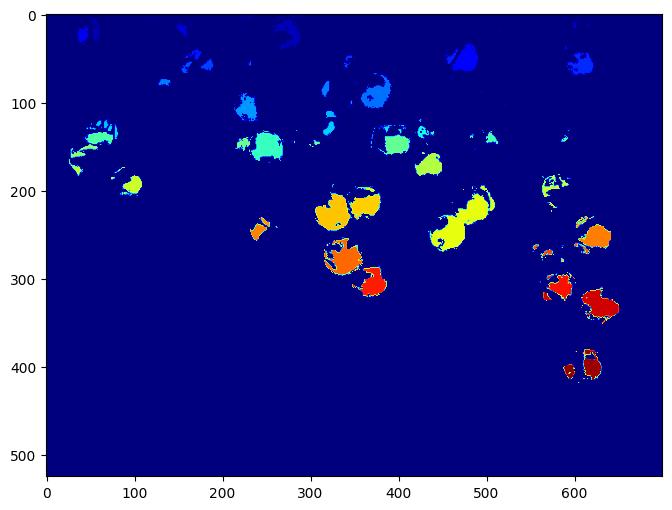

In [124]:
#add your code to find connected components
labels = measure.label(bin_img)
plt.imshow(labels,cmap="jet")

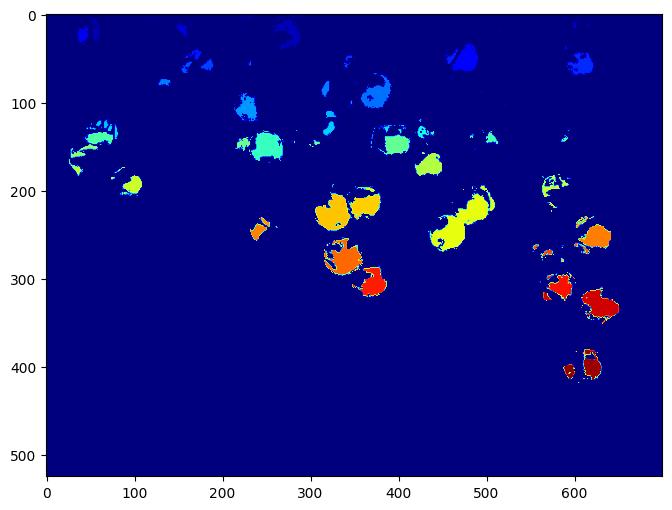

In [125]:
plt.imshow(labels,cmap="jet")

* Simple thresholding sometimes leads to detecting also noise in the background that is detected as seperate connected components. Try to suppress the noise by removing all connected components smaller than a user-defined threshold.

In [126]:
def remove_noise(label_img,threshold):
    #add your code here
    label_img_new = label_img.copy()
    for i in range(1, np.max(label_img)+1):
        if np.sum(label_img == i) < threshold:
            label_img_new[label_img == i] = 0
    return label_img_new

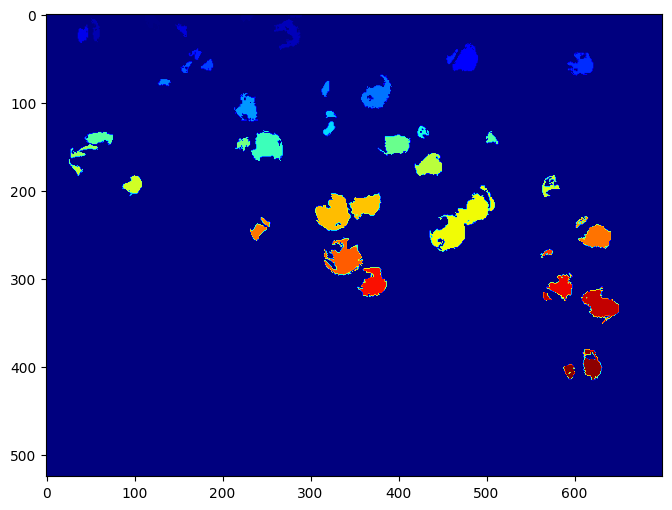

In [132]:
labels_new = remove_noise(labels, 50)
plt.imshow(labels_new,cmap="jet")